Here, we are importing the data before manipulating it so that each observation is an individual candidate with a new column called "total expenditures" representing their total funding for that campaign. We also create a new column 'contested' that indicates whether the candidate was contested in their election or not.

In [1]:
import pandas as pd
import numpy as np
import requests
from lxml import html
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [2]:
senate = pd.read_csv("senate.csv")
senate = senate.loc[:, ["expenditure_amount", "candidate_office_district","candidate_name","candidate_id", "candidate_first_name", "candidate_last_name","candidate_office", "candidate_office_state", "candidate_party"]]
senate_grouped = senate.groupby("candidate_id")["expenditure_amount"].sum().reset_index()
senate_grouped.rename(columns={"expenditure_amount": "total_expenditures"}, inplace=True)
senate = senate_grouped.merge(senate, how='left', on='candidate_id')
senate = senate.groupby(['candidate_name', 'candidate_id', 'candidate_first_name','candidate_last_name', 'candidate_office', 'candidate_office_state','candidate_party', 'candidate_office_district'])['total_expenditures'].first().reset_index()

senate['contested'] = 0
for state in senate['candidate_office_state'].unique():
    state_rows = senate[senate['candidate_office_state'] == state]
    num_candidates = len(state_rows)
    if num_candidates > 1:
        senate.loc[state_rows.index, 'contested'] = 1



house = pd.read_csv("house.csv")
house = house.loc[:, ["expenditure_amount", "candidate_name","candidate_office_district", "candidate_id", "candidate_first_name", "candidate_last_name", "candidate_office", "candidate_office_state", "candidate_party"]]
house_grouped = house.groupby("candidate_id")["expenditure_amount"].sum().reset_index()
house_grouped.rename(columns={"expenditure_amount": "total_expenditures"}, inplace=True)
house = house.loc[:, ["candidate_name", "candidate_id", "candidate_first_name", "candidate_last_name", "candidate_office", "candidate_office_state", "candidate_party", "candidate_office_district"]]
house = house_grouped.merge(house, how='left', on='candidate_id')
house = house.groupby('candidate_name').agg({
    'candidate_id': 'first',
    'candidate_first_name': 'first',
    'candidate_last_name': 'first',
    'candidate_office': 'first',
    'candidate_office_state': 'first',
    'candidate_party': 'first',
    'total_expenditures': 'first',
    'candidate_office_district': 'first'
}).reset_index()

# create a new column with default value 0
house['contested'] = 0
for i, row in house.iterrows():
    district = row['candidate_office_district']
    state = row['candidate_office_state']
    num_candidates = len(house[(house['candidate_office_district'] == district) & (house['candidate_office_state'] == state)])
    if num_candidates > 1:
        house.at[i, 'contested'] = 1

candidates = pd.concat([house, senate], ignore_index=True)
candidates['candidate_party_num'] = candidates['candidate_party'].apply(lambda x: 1 if x == 'DEM' else 0)
candidates['candidate_officeH_num'] = candidates['candidate_office'].apply(lambda x: 1 if x == 'H' else 0)
candidates['candidate_officeS_num'] = candidates['candidate_office'].apply(lambda x: 1 if x == 'S' else 0)
print(candidates.head())


/var/folders/_t/20ylglpx0p16yfczbx_x05480000gn/T/ipykernel_33658/840799253.py:1: DtypeWarning: Columns (15,68) have mixed types. Specify dtype option on import or set low_memory=False.
  senate = pd.read_csv("senate.csv")
/var/folders/_t/20ylglpx0p16yfczbx_x05480000gn/T/ipykernel_33658/840799253.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  house = pd.read_csv("house.csv")


        candidate_name candidate_id candidate_first_name candidate_last_name  \
0        AADLAND, ERIK    H2CO07170                 ERIK             AADLAND   
1  ADAMS, ALMA SHEALEY    H4NC12100                 ALMA               ADAMS   
2       ADKINS, AMANDA    H0KS03236               AMANDA              ADKINS   
3       ALEXANDER, TIM    H2NJ02193                  TIM           ALEXANDER   
4      ALFONSO, JOSEPH    H2MI04260               JOSEPH             ALFONSO   

  candidate_office candidate_office_state candidate_party  total_expenditures  \
0                H                     CO             REP           319384.85   
1                H                     NC             DEM             1779.24   
2                H                     KS             REP           147035.66   
3                H                     NJ             DEM              324.15   
4                H                     MI             DEM             4909.85   

  candidate_office_district  con

Now we are going to merge the candidates dataframe with a list of all current serving congressmembers, creating a new column for each candidate that is currently serving congress, indicating that they won their election.

In [3]:
currentmembers = pd.read_csv("currentmembers.csv")
new_df = pd.DataFrame(columns=["last_name", "first_name"])

# iterate through each row in the currentmembers dataframe
for index, row in currentmembers.iterrows():
    # get the full name and position string from the "Last Name, First Name - Position" column
    full_name_and_position = row["Last Name, First Name - Position"]
    # split the full name and position string by the ", " separator
    last_name, first_name_and_position = full_name_and_position.split(", ")
    # split the first name and position string by the " - " separator
    first_name, position = first_name_and_position.split(" - ")
    # add a new row to the new dataframe with the last name and first name
    new_row = {"last_name": last_name, "first_name": first_name}
    new_df = pd.concat([new_df, pd.DataFrame(new_row, index=[0])])

# reset the index of new_df
new_df = new_df.reset_index(drop=True)

# add the new "last_name" and "first_name" columns to the currentmembers dataframe
currentmembers["last_name"] = new_df["last_name"]
currentmembers["first_name"] = new_df["first_name"]
currentmembers = currentmembers.drop(columns=[col for col in currentmembers.columns if col not in ["last_name", "first_name"]])

candidates["win"] = 0

# iterate through each row in the "candidates" dataframe
for index, row in candidates.iterrows():
    # get the candidate first name and last name (only the first word), and convert to lowercase for case-insensitive comparison
    candidate_first_name = row["candidate_first_name"].split()[0].lower()
    candidate_last_name = row["candidate_last_name"].split()[0].lower()
    
    # search for a matching row in the "currentmembers" dataframe (only the first word of each column)
    matching_row = currentmembers[(currentmembers["first_name"].str.split().str[0].str.lower() == candidate_first_name) & (currentmembers["last_name"].str.split().str[0].str.lower() == candidate_last_name)]
    
    # if a matching row is found, set the "win" value in the "candidates" dataframe to 1
    if not matching_row.empty:
        candidates.at[index, "win"] = 1

print(candidates.shape[0])

1240


Now we are going to conduct hypothesis tests to test whether the mean funding of winning campaigns differs from that of losing campaigns. We are also going to test to see if the average money raised for winning campaigns differs depending on which election they are running in (house or senate). Then we will test to see if the average money raised by winning candidates differs by republican and democrat candidates. 

In [4]:
# split candidates dataframe into winning and losing dataframes
senate_winning_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'S'), 'total_expenditures']
senate_losing_expenditures = candidates.loc[(candidates['win'] == 0) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'S'), 'total_expenditures']

senate_t_stat, senate_p_value = stats.ttest_ind(senate_winning_expenditures, senate_losing_expenditures, equal_var=False)
print("Testing Winning vs Losing expenditures by houses")
print("Senate t-statistic: ", senate_t_stat)
print("Senate p-value: ", senate_p_value)


# conduct t-test for house
house_winning_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'H'), 'total_expenditures']
house_losing_expenditures = candidates.loc[(candidates['win'] == 0) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'H'), 'total_expenditures']

house_t_stat, house_p_value = stats.ttest_ind(house_winning_expenditures, house_losing_expenditures, equal_var=False)

print("House t-statistic: ", house_t_stat)
print("House p-value: ", house_p_value)


# winning expenditures by party and chamber
dem_senate_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['candidate_party'] == 'DEM') & (candidates['candidate_office'] == 'S'), 'total_expenditures']
rep_senate_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['candidate_party'] == 'REP') & (candidates['candidate_office'] == 'S'), 'total_expenditures']
dem_house_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['candidate_party'] == 'DEM') & (candidates['candidate_office'] == 'H'), 'total_expenditures']
rep_house_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['candidate_party'] == 'REP') & (candidates['candidate_office'] == 'H'), 'total_expenditures']

# t-tests
t_stat_senate, p_value_senate = stats.ttest_ind(dem_senate_expenditures, rep_senate_expenditures, equal_var=False)
t_stat_house, p_value_house = stats.ttest_ind(dem_house_expenditures, rep_house_expenditures, equal_var=False)

# print results
print("\nTesting Dems vs Reps winning expenditures by houses")
print("Senate t-statistic: ", t_stat_senate)
print("Senate p-value: ", p_value_senate)

print("House t-statistic: ", t_stat_house)
print("House p-value: ", p_value_house)


# filter the data to only include winning, contested candidates
winning_contested = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1)]

# split the data by candidate_house
house_winning = winning_contested.loc[winning_contested['candidate_office'] == 'H', 'total_expenditures']
senate_winning = winning_contested.loc[winning_contested['candidate_office'] == 'S', 'total_expenditures']

# conduct t-test
t_stat, p_value = stats.ttest_ind(house_winning, senate_winning, equal_var=False)

# print results
print("\nTesting House vs Senate winning expenditures")
print("t-statistic: ", t_stat)
print("p-value: ", p_value)


Testing Winning vs Losing expenditures by houses
Senate t-statistic:  -1.6722844892527124
Senate p-value:  0.09521631378687019
House t-statistic:  1.8735132830889387
House p-value:  0.06171259436012465

Testing Dems vs Reps winning expenditures by houses
Senate t-statistic:  -0.7622015945030814
Senate p-value:  0.4471185993190999
House t-statistic:  1.760950503091844
House p-value:  0.07953606366279958

Testing House vs Senate winning expenditures
t-statistic:  -6.658779728206739
p-value:  2.8004010296714357e-10


NameError: name 'plt' is not defined

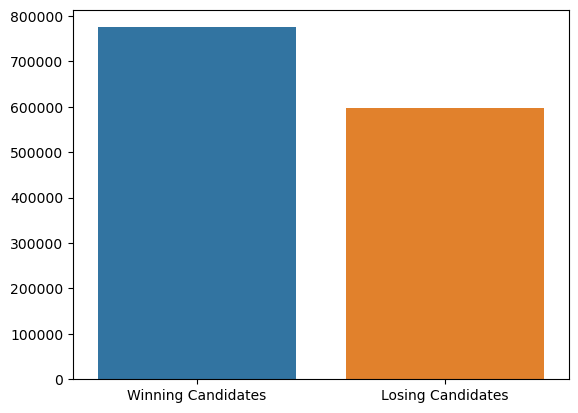

In [5]:
house_winning_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'H'), 'total_expenditures']
house_losing_expenditures = candidates.loc[(candidates['win'] == 0) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'H'), 'total_expenditures']

# Calculate means
win_mean = house_winning_expenditures.mean()
lose_mean = house_losing_expenditures.mean()

# Plot the barplot
sns.barplot(x=['Winning Candidates', 'Losing Candidates'], y=[win_mean, lose_mean])
plt.title('Winning vs Losing Expenditures in House of Representatives Races')
plt.ylabel('Average Expenditures')
plt.show()

senate_winning_expenditures = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'S'), 'total_expenditures']
senate_losing_expenditures = candidates.loc[(candidates['win'] == 0) & (candidates['contested'] == 1) & (candidates['candidate_office'] == 'S'), 'total_expenditures']

# Calculate means
win_mean = senate_winning_expenditures.mean()
lose_mean = senate_losing_expenditures.mean()

# Plot the barplot
sns.barplot(x=['Winning Candidates', 'Losing Candidates'], y=[win_mean, lose_mean])
plt.title('Winning vs Losing Expenditures in Senate Races')
plt.ylabel('Average Expenditures')
plt.show()

In [6]:
winning_contested = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1)]

# filter the data to only include House of Representatives candidates
house_winning_contested = winning_contested.loc[winning_contested['candidate_office'] == 'H']

# calculate average expenditures for winning Democratic and Republican House candidates
dem_house_expenditures = house_winning_contested.loc[house_winning_contested['candidate_party'] == 'DEM', 'total_expenditures'].mean()
rep_house_expenditures = house_winning_contested.loc[house_winning_contested['candidate_party'] == 'REP', 'total_expenditures'].mean()

# create a bar plot for House of Representatives
plt.figure(figsize=(10, 6))
sns.barplot(x=['Democrats', 'Republicans'], y=[dem_house_expenditures, rep_house_expenditures], palette=['blue', 'red'])
plt.title('Average Expenditures for Winning House Of Representatives Candidates by Party', fontsize=16)
plt.ylabel('Average Expenditures', fontsize=14)
plt.xlabel('Party', fontsize=14)
plt.show()

# filter the data to only include Senate candidates
senate_winning_contested = winning_contested.loc[winning_contested['candidate_office'] == 'S']

# calculate average expenditures for winning Democratic and Republican Senate candidates
dem_senate_expenditures = senate_winning_contested.loc[senate_winning_contested['candidate_party'] == 'DEM', 'total_expenditures'].mean()
rep_senate_expenditures = senate_winning_contested.loc[senate_winning_contested['candidate_party'] == 'REP', 'total_expenditures'].mean()

# create a bar plot for Senate
plt.figure(figsize=(10, 6))
sns.barplot(x=['Democrats', 'Republicans'], y=[dem_senate_expenditures, rep_senate_expenditures], palette=['blue', 'red'])
plt.title('Average Expenditures for Winning Senate Candidates by Party', fontsize=16)
plt.ylabel('Average Expenditures', fontsize=14)
plt.xlabel('Party', fontsize=14)
plt.show()

NameError: name 'plt' is not defined

In [7]:
winning_contested = candidates.loc[(candidates['win'] == 1) & (candidates['contested'] == 1)]

# split the data by candidate_house
house_winning = winning_contested.loc[winning_contested['candidate_office'] == 'H', 'total_expenditures']
senate_winning = winning_contested.loc[winning_contested['candidate_office'] == 'S', 'total_expenditures']

# create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=['House', 'Senate'], y=[house_winning.mean(), senate_winning.mean()], palette=['orange', 'green'], ax=ax)

# set labels and title
ax.set_xlabel('Candidate Office')
ax.set_ylabel('Average Expenditures (USD)')
ax.set_title('Average Expenditures for Winning Candidates by House')

# show plot
plt.show()

NameError: name 'plt' is not defined

Statistics on training data: 
 	R^2:  0.5607974481658693  
 	MSE:  0.3508982035928144 
 	Accuracy:  0.6491017964071857 

Statistics on testing data: 
 	R^2:  0.5087090163934427  
 	MSE:  0.34050179211469533 
 	Accuracy:  0.6594982078853047 

Baseline accuracy (proportion of observations in data where candidate loses):  0.6579892280071813 

More testing data statistics:
	Model precision:  0.5263157894736842
	Model recall:  0.10416666666666667
	Model F1:  0.17391304347826086 

Coefficients: [[-9.76236758e-08 -1.59697937e-13 -6.35966043e-13 -1.81845207e-13
  -2.15187215e-09 -1.68142311e-07  7.05186350e-08 -1.64615885e-13
   4.91794789e-15]] 



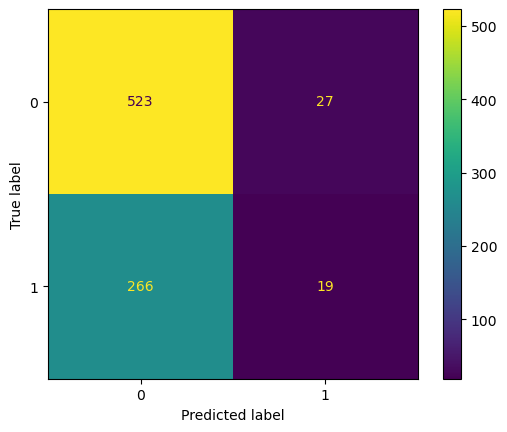

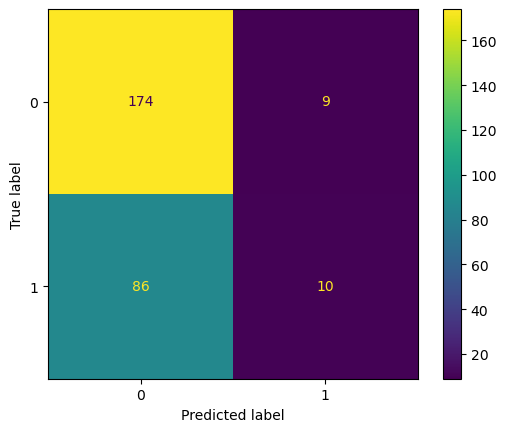

In [17]:
#model creation
import statsmodels.api as sm
import scipy.special
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import ConfusionMatrixDisplay

# feature selection
candidates = candidates.drop(candidates[candidates.contested == 0].index)
X = candidates[['total_expenditures', 'candidate_party_num', 'candidate_officeH_num', 'candidate_officeS_num']]
X  = np.c_[X, X['total_expenditures'] * X['candidate_party_num'], X['total_expenditures'] * X['candidate_officeH_num'], X['total_expenditures'] * X['candidate_officeS_num'], X['candidate_party_num'] * X['candidate_officeH_num'], X['candidate_party_num'] * X['candidate_officeS_num']]
y = candidates['win']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# model selection
model = LogisticRegression()

# train model
model.fit(X_train, y_train)
predict_prob = model.predict_proba(X_train)
predict_prob_win = predict_prob[:,1]
threshold = 0.4999
predict = [1 if prob > threshold else 0 for prob in predict_prob_win]

# model eval
train_stats = np.zeros(3)
train_stats[0] = r2_score(y_train, predict) * -1
train_stats[1] = mean_squared_error(y_train, predict)
train_stats[2] = accuracy_score(y_train, predict)
print('Statistics on training data: \n \tR^2: ', train_stats[0], ' \n \tMSE: ', train_stats[1], '\n \tAccuracy: ', train_stats[2], '\n')

y_pred_prob = model.predict_proba(X_test)
y_pred_win = y_pred_prob[:,1]
y_pred = [1 if prob > threshold else 0 for prob in y_pred_win]
test_stats = np.zeros(3)
test_stats[0] = r2_score(y_test, y_pred) * -1
test_stats[1] = mean_squared_error(y_test, y_pred)
test_stats[2] = accuracy_score(y_test, y_pred)
print('Statistics on testing data: \n \tR^2: ', test_stats[0], ' \n \tMSE: ', test_stats[1], '\n \tAccuracy: ', test_stats[2], '\n')

print('Baseline accuracy (proportion of observations in data where candidate loses): ', (candidates['win'] == 0).sum()/candidates.shape[0], '\n')

print('More testing data statistics:')
print('\tModel precision: ', 10/(10+9))
print('\tModel recall: ', 10/(10+86))
print('\tModel F1: ', 2 * ((10/(10+9))*(10/(10+86)))/((10/(10+9))+(10/(10+86))), '\n')

ConfusionMatrixDisplay.from_predictions(y_train, predict)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# print model stats
print('Coefficients:', model.coef_, '\n')
